In [2]:
import pandas as pd
# import os
from datetime import datetime, timedelta
import re

import numpy as np

from pandas.tseries.offsets import BDay

import os, sys
module_path = os.path.abspath(os.path.join('./download-tick-from-dukascopy'))
if module_path not in sys.path:
    sys.path.append(module_path)
import download_tick_from_dukascopy

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

path = 'data'
inst_txt_path = 'insts.txt'

DATE_RANGE = 5

In [ ]:
# inst = 'BTCUSD'
# inst = 'USA500IDXUSD'
# inst = 'USATECHIDXUSD'

# if inst not in os.listdir(path):
#     os.mkdir('{}/{}'.format(path, inst))
    
#
#   To do:
#       - Check if already in data
#       - Download days you don't have
#
    
# gotta loop through this, and handle no columns (1kb .csv)

# check handling quitting


In [4]:
def get_all(inst):
    # concat all .csvs within dir
    data = pd.DataFrame()
    
    files = [
        file for file 
        in os.listdir('{}/{}'.format(path, inst)) 
        if os.path.getsize('{}/{}/{}'.format(path, inst, file)) > 2
    ]
    
    for csv in files:
        data = pd.concat([
            data,
            pd.read_csv(
                '{}/{}/{}'.format(path, inst, csv),
                header=None
            )
        ])
    data.columns = ['dt', 'bid', 'ask', 'bidvol', 'askvol']
    return data


def clean(inst):
    data = get_all(inst)
    # dd = len(data)
    data = data.drop_duplicates()
    # print('{} duplicate rows dropped'.format(dd-len(data)))
    # data = data.sort_values('dt')
    # print('max: {}'.format(data['dt'].max()))
    data['mid'] = (data['bid'] + data['ask']) / 2
    data.index = data['dt'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S.%f'))
    data = data[['mid']].resample('1Min').ohlc()
    return data

In [5]:
# # inst = 'USATECHIDXUSD'
# # inst = 'BTCUSD'
# inst = 'USA500IDXUSD'

# data = clean(inst)
# data

In [6]:
# # take last datetime, find difference from current date
# # datetime.strptime(data.index.max(), '%Y-%m-%d %H:%M:%S.%f')
# (datetime.now() - data.index.max()).days

In [7]:
# # just get last week because it's less annoying
# datetime.strftime((datetime.now() - timedelta(7)), '%Y-%m-%d')

In [8]:
# class insts list

# class inst
    # start date
    # end date
    # write to csv
    # do things

In [9]:
# with open(inst_txt_path, 'r') as f:
#     insts = f.read().split('\n')
# print(insts)

# for inst in insts:
#     print(inst)
#     if inst not in os.listdir(path):
#         os.mkdir('{}/{}'.format(path, inst))
#     print(os.listdir('{}/{}'.format(path, inst)))
    
#     # consider making some meta-file that keeps last updated date instead of concatting everytime
    

In [10]:
def check_max(inst):
    
    # Returns min/max date from current data by:
    # 1.) Finding max filename (doesn't account for end date of data .csv)
    # 2.) Finding max date within that file (doesn't account for gaps)
    
    files = [
        file for file 
        in os.listdir('{}/{}'.format(path, inst)) 
        if os.path.getsize('{}/{}/{}'.format(path, inst, file)) > 2
    ]
    
    if files:
    
        # Check
        csv = max(files)
        inst_max = re.search('[0-9]{4}-[0-9]{2}-[0-9]{2}', max(files)).group(0)

        #     data = pd.read_csv('{}/{}/{}'.format(path, inst, csv), header=None)
        #     data.columns = ['dt', 'bid', 'ask', 'bidvol', 'askvol']
        #     # data = data.drop_duplicates()
        #     data.index = data['dt'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S.%f'))
        #     # data = data[['bid']].resample('1Min').first()
        #     inst_max = data.index.max().date()

        # Get min date data
        csv = min(files)
        inst_min = re.search('[0-9]{4}-[0-9]{2}-[0-9]{2}', min(files)).group(0)

        #     data = pd.read_csv('{}/{}/{}'.format(path, inst, csv), header=None)
        #     data.columns = ['dt', 'bid', 'ask', 'bidvol', 'askvol']
        #     data.index = data['dt'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S.%f'))
        #     inst_max = data.index.max().date()
        
    else:
        
        # inst_max = datetime.strftime(datetime.today(), '%Y-%m-%d')
        # inst_min = datetime.strftime((datetime.today() - BDay(DATE_RANGE)).date(), '%Y-%m-%d')
        inst_min = False
        inst_max = False
    
    return inst_min, inst_max


def download(inst, start_date, end_date):
    
    # given start and end date, download each inst a day at a time
    
    start_dt = datetime.strptime(start_date, '%Y-%m-%d')
    end_dt = datetime.strptime(end_date, '%Y-%m-%d')
    diff = (end_dt - start_dt).days
    date_list = [datetime.strftime(end_dt - timedelta(days=x), '%Y-%m-%d') for x in range(0, diff)]
    
    for date in date_list:
        download_tick_from_dukascopy.main(inst, date, date, './{}/{}'.format(path, inst))

        
def check_current(inst):
    
    # check current date against last updated date for all inst's
    
    inst_min, inst_max = check_max(inst)

    if all([inst_min, inst_max]):
    
        # Checking start date
        # If min < than this, you're good.
        if datetime.strptime(inst_min, '%Y-%m-%d').date() < (datetime.today() - BDay(DATE_RANGE)).date():
            print('start date good')

        # Else, download from this to whereever the min was.  
        else:
            to_download_start = datetime.strftime((datetime.today() - BDay(DATE_RANGE)).date(), '%Y-%m-%d')
            to_download_end = inst_min

            download(inst, to_download_start, to_download_end)

        # Checking end date
        if datetime.strptime(inst_max, '%Y-%m-%d').date() == datetime.today().date():
            print('end date good')

        # else, download from max to today
        else:
            to_download_start = inst_max
            to_download_end = datetime.strftime(datetime.today(), '%Y-%m-%d')

            download(inst, to_download_start, to_download_end)
            
    else:
        to_download_start = datetime.strftime((datetime.today() - BDay(DATE_RANGE)).date(), '%Y-%m-%d')
        to_download_end = datetime.strftime(datetime.today(), '%Y-%m-%d')

        download(inst, to_download_start, to_download_end)

    return



def handle_check(inst):
    
    tries = 0
    
    try:
        check_current(inst)
    except OSError as e: # may be redundant if handling in update()
        print(e)
        
        if inst not in os.listdir(path):
            os.mkdir('{}/{}'.format(path, inst))
        
        handle_check(inst)
    except urllib2.URLError as e: # not sure if this wil work, will have to check later... could make inf loop
        print('URLError', e)
        tries += handle_check(inst)
        print('e tries', tries)
        
    print('all tries', tries)
    return tries

In [11]:
def update():
    
    # update all things
        
    with open(inst_txt_path, 'r') as f:
        insts = f.read().split('\n')
    print(insts)

    for inst in insts:
        print(inst)
        if inst not in os.listdir(path):
            os.mkdir('{}/{}'.format(path, inst))
        # print(os.listdir('{}/{}'.format(path, inst)))
        
        handle_check(inst)
    
    # consider making some meta-file that keeps last updated date instead of concatting everytime
    
    
    
    return

In [12]:
update()

['GBPUSD', 'BTCUSD', 'USA500IDXUSD', 'USATECHIDXUSD']
GBPUSD
start date good
downloading: https://datafeed.dukascopy.com/datafeed/GBPUSD/2021/03/28/00h_ticks.bi5
download failed. continuing..
downloading: https://datafeed.dukascopy.com/datafeed/GBPUSD/2021/03/28/01h_ticks.bi5
download failed. continuing..
downloading: https://datafeed.dukascopy.com/datafeed/GBPUSD/2021/03/28/02h_ticks.bi5
download failed. continuing..
downloading: https://datafeed.dukascopy.com/datafeed/GBPUSD/2021/03/28/03h_ticks.bi5
download failed. continuing..
downloading: https://datafeed.dukascopy.com/datafeed/GBPUSD/2021/03/28/04h_ticks.bi5
download failed. continuing..
downloading: https://datafeed.dukascopy.com/datafeed/GBPUSD/2021/03/28/05h_ticks.bi5
download failed. continuing..
downloading: https://datafeed.dukascopy.com/datafeed/GBPUSD/2021/03/28/06h_ticks.bi5
download failed. continuing..
downloading: https://datafeed.dukascopy.com/datafeed/GBPUSD/2021/03/28/07h_ticks.bi5
download failed. continuing..
dow

downloading: https://datafeed.dukascopy.com/datafeed/GBPUSD/2021/03/25/14h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/GBPUSD/2021/03/25/15h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/GBPUSD/2021/03/25/16h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/GBPUSD/2021/03/25/17h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/GBPUSD/2021/03/25/18h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/GBPUSD/2021/03/25/19h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/GBPUSD/2021/03/25/20h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/GBPUSD/2021/03/25/21h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/GBPUSD/2021/03/25/22h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/GBPUSD/2021/03/25/23h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/GBPUSD/2021/03/24/00h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/GBPUSD/2021/

download failed. continuing..
downloading: https://datafeed.dukascopy.com/datafeed/GBPUSD/2021/03/28/19h_ticks.bi5
download failed. continuing..
downloading: https://datafeed.dukascopy.com/datafeed/GBPUSD/2021/03/28/20h_ticks.bi5
download failed. continuing..
downloading: https://datafeed.dukascopy.com/datafeed/GBPUSD/2021/03/28/21h_ticks.bi5
download failed. continuing..
downloading: https://datafeed.dukascopy.com/datafeed/GBPUSD/2021/03/28/22h_ticks.bi5
download failed. continuing..
downloading: https://datafeed.dukascopy.com/datafeed/GBPUSD/2021/03/28/23h_ticks.bi5
download failed. continuing..
all tries 0
all tries 0
BTCUSD
start date good
downloading: https://datafeed.dukascopy.com/datafeed/BTCUSD/2021/03/28/00h_ticks.bi5
download failed. continuing..
downloading: https://datafeed.dukascopy.com/datafeed/BTCUSD/2021/03/28/01h_ticks.bi5
download failed. continuing..
downloading: https://datafeed.dukascopy.com/datafeed/BTCUSD/2021/03/28/02h_ticks.bi5
download failed. continuing..
dow

downloading: https://datafeed.dukascopy.com/datafeed/BTCUSD/2021/03/25/06h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/BTCUSD/2021/03/25/07h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/BTCUSD/2021/03/25/08h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/BTCUSD/2021/03/25/09h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/BTCUSD/2021/03/25/10h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/BTCUSD/2021/03/25/11h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/BTCUSD/2021/03/25/12h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/BTCUSD/2021/03/25/13h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/BTCUSD/2021/03/25/14h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/BTCUSD/2021/03/25/15h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/BTCUSD/2021/03/25/16h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/BTCUSD/2021/

download failed. continuing..
downloading: https://datafeed.dukascopy.com/datafeed/USA500IDXUSD/2021/03/28/18h_ticks.bi5
download failed. continuing..
downloading: https://datafeed.dukascopy.com/datafeed/USA500IDXUSD/2021/03/28/19h_ticks.bi5
download failed. continuing..
downloading: https://datafeed.dukascopy.com/datafeed/USA500IDXUSD/2021/03/28/20h_ticks.bi5
download failed. continuing..
downloading: https://datafeed.dukascopy.com/datafeed/USA500IDXUSD/2021/03/28/21h_ticks.bi5
download failed. continuing..
downloading: https://datafeed.dukascopy.com/datafeed/USA500IDXUSD/2021/03/28/22h_ticks.bi5
download failed. continuing..
downloading: https://datafeed.dukascopy.com/datafeed/USA500IDXUSD/2021/03/28/23h_ticks.bi5
download failed. continuing..
downloading: https://datafeed.dukascopy.com/datafeed/USA500IDXUSD/2021/03/27/00h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/USA500IDXUSD/2021/03/27/01h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/USA500IDX

downloading: https://datafeed.dukascopy.com/datafeed/USA500IDXUSD/2021/03/24/08h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/USA500IDXUSD/2021/03/24/09h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/USA500IDXUSD/2021/03/24/10h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/USA500IDXUSD/2021/03/24/11h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/USA500IDXUSD/2021/03/24/12h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/USA500IDXUSD/2021/03/24/13h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/USA500IDXUSD/2021/03/24/14h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/USA500IDXUSD/2021/03/24/15h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/USA500IDXUSD/2021/03/24/16h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/USA500IDXUSD/2021/03/24/17h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/USA500IDXUSD/2021/03/24/18h_ticks.bi5

downloading: https://datafeed.dukascopy.com/datafeed/USA500IDXUSD/2021/03/20/04h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/USA500IDXUSD/2021/03/20/05h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/USA500IDXUSD/2021/03/20/06h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/USA500IDXUSD/2021/03/20/07h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/USA500IDXUSD/2021/03/20/08h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/USA500IDXUSD/2021/03/20/09h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/USA500IDXUSD/2021/03/20/10h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/USA500IDXUSD/2021/03/20/11h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/USA500IDXUSD/2021/03/20/12h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/USA500IDXUSD/2021/03/20/13h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/USA500IDXUSD/2021/03/20/14h_ticks.bi5

downloading: https://datafeed.dukascopy.com/datafeed/USA500IDXUSD/2021/03/16/00h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/USA500IDXUSD/2021/03/16/01h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/USA500IDXUSD/2021/03/16/02h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/USA500IDXUSD/2021/03/16/03h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/USA500IDXUSD/2021/03/16/04h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/USA500IDXUSD/2021/03/16/05h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/USA500IDXUSD/2021/03/16/06h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/USA500IDXUSD/2021/03/16/07h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/USA500IDXUSD/2021/03/16/08h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/USA500IDXUSD/2021/03/16/09h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/USA500IDXUSD/2021/03/16/10h_ticks.bi5

downloading: https://datafeed.dukascopy.com/datafeed/USA500IDXUSD/2021/03/13/20h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/USA500IDXUSD/2021/03/13/21h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/USA500IDXUSD/2021/03/13/22h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/USA500IDXUSD/2021/03/13/23h_ticks.bi5
all tries 0
USATECHIDXUSD
start date good
downloading: https://datafeed.dukascopy.com/datafeed/USATECHIDXUSD/2021/03/28/00h_ticks.bi5
download failed. continuing..
downloading: https://datafeed.dukascopy.com/datafeed/USATECHIDXUSD/2021/03/28/01h_ticks.bi5
download failed. continuing..
downloading: https://datafeed.dukascopy.com/datafeed/USATECHIDXUSD/2021/03/28/02h_ticks.bi5
download failed. continuing..
downloading: https://datafeed.dukascopy.com/datafeed/USATECHIDXUSD/2021/03/28/03h_ticks.bi5
download failed. continuing..
downloading: https://datafeed.dukascopy.com/datafeed/USATECHIDXUSD/2021/03/28/04h_ticks.bi5
download faile

downloading: https://datafeed.dukascopy.com/datafeed/USATECHIDXUSD/2021/03/25/04h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/USATECHIDXUSD/2021/03/25/05h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/USATECHIDXUSD/2021/03/25/06h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/USATECHIDXUSD/2021/03/25/07h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/USATECHIDXUSD/2021/03/25/08h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/USATECHIDXUSD/2021/03/25/09h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/USATECHIDXUSD/2021/03/25/10h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/USATECHIDXUSD/2021/03/25/11h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/USATECHIDXUSD/2021/03/25/12h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/USATECHIDXUSD/2021/03/25/13h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/USATECHIDXUSD/2021/03/25/14

downloading: https://datafeed.dukascopy.com/datafeed/USATECHIDXUSD/2021/03/22/23h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/USATECHIDXUSD/2021/03/21/00h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/USATECHIDXUSD/2021/03/21/01h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/USATECHIDXUSD/2021/03/21/02h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/USATECHIDXUSD/2021/03/21/03h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/USATECHIDXUSD/2021/03/21/04h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/USATECHIDXUSD/2021/03/21/05h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/USATECHIDXUSD/2021/03/21/06h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/USATECHIDXUSD/2021/03/21/07h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/USATECHIDXUSD/2021/03/21/08h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/USATECHIDXUSD/2021/03/21/09

downloading: https://datafeed.dukascopy.com/datafeed/USATECHIDXUSD/2021/03/18/18h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/USATECHIDXUSD/2021/03/18/19h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/USATECHIDXUSD/2021/03/18/20h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/USATECHIDXUSD/2021/03/18/21h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/USATECHIDXUSD/2021/03/18/22h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/USATECHIDXUSD/2021/03/18/23h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/USATECHIDXUSD/2021/03/17/00h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/USATECHIDXUSD/2021/03/17/01h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/USATECHIDXUSD/2021/03/17/02h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/USATECHIDXUSD/2021/03/17/03h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/USATECHIDXUSD/2021/03/17/04

downloading: https://datafeed.dukascopy.com/datafeed/USATECHIDXUSD/2021/03/14/12h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/USATECHIDXUSD/2021/03/14/13h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/USATECHIDXUSD/2021/03/14/14h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/USATECHIDXUSD/2021/03/14/15h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/USATECHIDXUSD/2021/03/14/16h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/USATECHIDXUSD/2021/03/14/17h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/USATECHIDXUSD/2021/03/14/18h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/USATECHIDXUSD/2021/03/14/19h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/USATECHIDXUSD/2021/03/14/20h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/USATECHIDXUSD/2021/03/14/21h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/USATECHIDXUSD/2021/03/14/22

In [12]:
# with open(inst_txt_path, 'r') as f:
#     insts = f.read().split('\n')
# print(insts)

# for inst in insts:
#     print(inst)
#     if inst not in os.listdir(path):
#         os.mkdir('{}/{}'.format(path, inst))
#     print(os.listdir('{}/{}'.format(path, inst)))
    
#     # consider making some meta-file that keeps last updated date instead of concatting everytime  

In [13]:
%%time
# Try getting avg rotations
inst = 'USA500IDXUSD'
data = clean(inst)

Wall time: 11.3 s


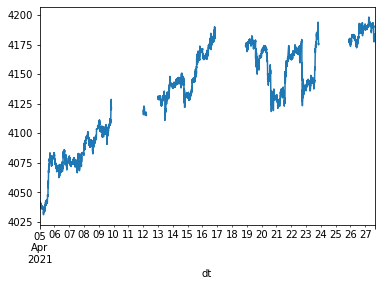

In [14]:
data = data['mid']
data['close'].plot()

In [15]:
# Get sign of each bar (-1, 0, 1)
data['sign'] = np.sign(data['close'] - data['open'])

# Group together (including 0's at end of group)
prev = data['sign'][0]
g = 0
for i, s in tqdm(zip(data.index, data['sign'])):
    if s == 1:
        if prev == 1:
            # continue up group
            # print(i, s, 'yes', g)
            data.loc[i, 'g'] = g
        else:
            # new up group
            # iterate group
            g += 1
            # print(i, s, 'new', g)
            data.loc[i, 'g'] = g
    if s == -1:
        if prev == -1:
            # continue down group
            # print(i, s, 'yes', g)
            data.loc[i, 'g'] = g
        else:
            # new down group
            # iterate group
            g += 1
            # print(i, s, 'new', g)
            data.loc[i, 'g'] = g
    if s == 0:
        # add to last group
        # print(i, s, 'add to last', g)
        data.loc[i, 'g'] = g
    prev = s
    
# Now I'm thinking of grouping them two legs (of single "rotation") together
# If it's down/up, find the low.
# If it's up/down, find the high.
# This gets us the most accurate points for each rotation.


r = []
for x in tqdm(range(int(max(data['g'])))):
    # if g == x or x+1, find min/max
    # if g sign is +, find the +/- rot (high)
    # if g sign is -, find -/+ rot (low)
    
    if data.loc[data['g'] == x, 'sign'].iloc[0] > 0:
        h = data.loc[(data['g'] == x) | (data['g'] == x+1), 'high']
        i = h.idxmax()
        h = h.max()
        # data.loc[i, 'r'] = h
        r.append([i, h])
    if data.loc[data['g'] == x, 'sign'].iloc[0] < 0:
        l = data.loc[(data['g'] == x) | (data['g'] == x+1), 'low']
        i = l.idxmin()
        l = l.min()
        # data.loc[i, 'r'] = l
        r.append([i, l])

In [16]:
data

,open,high,low,close,sign,g
dt,,,,,,
2021-04-05 00:00:00,4042.5660,4042.7075,4040.9685,4042.1985,-1.0,0.0
2021-04-05 00:01:00,4042.3465,4042.5045,4040.9985,4040.9985,-1.0,0.0
2021-04-05 00:02:00,4041.0950,4041.2075,4040.6970,4040.9925,-1.0,0.0
2021-04-05 00:03:00,4040.8505,4041.0075,4040.5105,4040.9955,1.0,1.0
2021-04-05 00:04:00,4040.8490,4041.9955,4040.7045,4041.9955,1.0,1.0
...,...,...,...,...,...,...
2021-04-27 14:55:00,4183.2000,4184.6970,4182.8775,4183.6970,1.0,10438.0
2021-04-27 14:56:00,4183.4555,4183.4555,4182.8685,4183.2075,-1.0,10439.0
2021-04-27 14:57:00,4182.9015,4183.7270,4182.8745,4182.8745,-1.0,10439.0


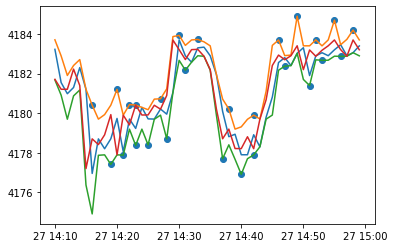

In [17]:
plt.plot(data[['open', 'high', 'low', 'close']][-50:])
plt.scatter([x[0] for x in r[-27:]], [x[1] for x in r[-27:]])

In [22]:
# Now I'm thinking of grouping them two legs (of single "rotation") together
# If it's down/up, find the low.
# If it's up/down, find the high.
# This gets us the most accurate points for each rotation.

r = []
for x in tqdm(range(int(max(data['g'])))):
    # if g == x or x+1, find min/max
    # if g sign is +, find the +/- rot (high)
    # if g sign is -, find -/+ rot (low)
    
    if data.loc[data['g'] == x, 'sign'].iloc[0] > 0:
        h = data.loc[(data['g'] == x) | (data['g'] == x+1), 'high']
        i = h.idxmax()
        h = h.max()
        # data.loc[i, 'r'] = h
        r.append([i, h])
    if data.loc[data['g'] == x, 'sign'].iloc[0] < 0:
        l = data.loc[(data['g'] == x) | (data['g'] == x+1), 'low']
        i = l.idxmin()
        l = l.min()
        # data.loc[i, 'r'] = l
        r.append([i, l])

In [23]:
r = pd.DataFrame(r)
r['d'] = r[1].diff()
r['ad'] = abs(r['d'])

In [24]:
# dependent on scaling
# r[['d', 'ad']] = r[['d', 'ad']] * 10000

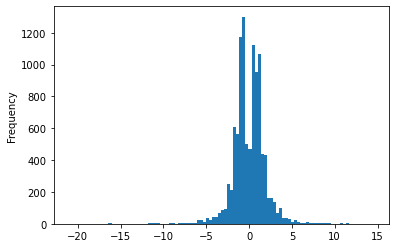

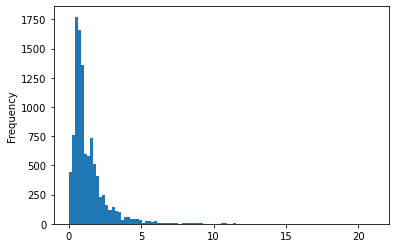

In [25]:
r['d'].plot(kind='hist', bins=100)
plt.show()
r['ad'].plot(kind='hist', bins=100)
plt.show()

In [26]:
r['ad'].describe()

count    10440.000000
mean         1.336370
std          1.294604
min          0.000000
25%          0.534500
50%          1.007500
75%          1.548000
max         21.031500
Name: ad, dtype: float64

In [27]:
r

,0,1,d,ad
0,2021-04-05 00:03:00,4040.5105,NaN,NaN
1,2021-04-05 00:06:00,4042.7270,2.2165,2.2165
2,2021-04-05 00:13:00,4039.1925,-3.5345,3.5345
3,2021-04-05 00:13:00,4039.7270,0.5345,0.5345
4,2021-04-05 00:15:00,4038.9925,-0.7345,0.7345
...,...,...,...,...
10436,2021-04-27 14:52:00,4183.7030,2.3090,2.3090
10437,2021-04-27 14:53:00,4182.6685,-1.0345,1.0345
10438,2021-04-27 14:55:00,4184.6970,2.0285,2.0285
10439,2021-04-27 14:56:00,4182.8685,-1.8285,1.8285


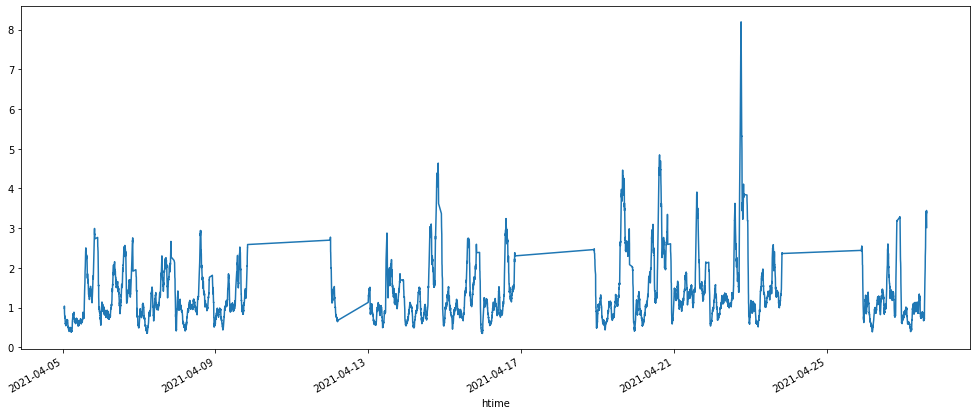

In [28]:
r['adr'] = r['ad'].rolling(30).mean()
r['htime'] = r[0]
# r.set_index('htime')['adr'].dropna().plot(figsize=(13, 5))

r.set_index('htime')['adr'].plot(
    figsize=(17,7)
)

In [29]:
# r.quantile(.90)

1      4180.37750
d         1.98500
ad        2.62870
adr       2.35315
Name: 0.9, dtype: float64

In [30]:
r.quantile(.95)

1      4188.691000
d         2.734650
ad        3.534575
adr       2.805942
Name: 0.95, dtype: float64